<a href="https://colab.research.google.com/github/CoderAPS/neural_nets/blob/main/image_segmentation2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install tensorflow_examples
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-zwlr4njs
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-zwlr4njs
  Resolved https://github.com/tensorflow/examples.git to commit f2b560e341ee0b21f1b8a0f351077a656fff7336
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-f2b560e341ee0b21f1b8a0f351077a656fff7336_-py3-none-any.whl size=299718 sha256=b257218b3fa27ad7de55deabfbdde481164ead41f5a54b3f3596dd2515d53824
  Stored in directory: /tmp/pip-ephem-wheel-cache-gmx03o7y/wheels/4e/f5/c2/bfe75b834c9028b2529023bf74541c46ead531b513a8010d21
Failed to build tensorflow-examples
  Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel c

In [2]:
# import some tensorflow and some python visualization librararies 
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow import keras

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
# download Oxford-IIIT Pets dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQ879MH/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQ879MH/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
dataset

{'train': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [5]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path=PosixGPath('/tmp/tmp92uf1eyqtfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        

In [6]:
number_classes = info.features['label'].num_classes
print(f'Number of classes in dataset: {number_classes}')

Number of classes in dataset: 37


In [7]:
info.splits['train'].num_examples

3680

In [8]:
info.splits['test'].num_examples

3669

The masks are class-labels for each pixel. Each pixel is given one of three categories:<br>

Class 1: Pixel belonging to the pet.<br>
Class 2: Pixel bordering the pet.<br>
Class 3: None of the above/a surrounding pixel.

In [9]:
def normalize(input_image, input_mask):
  #the image color values are normalized to the [0, 1] range
  input_image = tf.cast(input_image, tf.float32) / 255.0

  # original segmentation mask labeled as {1, 2, 3}, for convenience, 
  # subtract 1 from the segmentation mask, resulting in labels 
  # that are : {0, 1, 2}
  input_mask -= 1

  return input_image, input_mask


In [10]:
def load_image(datapoint):
  # resize images to 128 by 128
  input_image = tf.image.resize(datapoint['image'], (128, 128))

  # resize segmentation_mask to 128 by 128
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [11]:
dataset

{'train': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [12]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
train_images

<ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>

In [14]:
# Semantic segmentation datasets can be highly imbalanced meaning that 
# particular class pixels can be present more inside images than that of other 
# classes. Since segmentation problems can be treated as per-pixel 
# classification problems, you can deal with the imbalance problem by weighing 
# the loss function to account for this.

# make sample weights for dataset to correct for imbalanced dataset 

def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [ ]:
img = train_images.take(1)
i,l,sw = add_sample_weights(img,[2,2,1])

In [ ]:
print('Output for add_sample_weights function:')
print(f'image: {i}\nlabel: {l}\nsample_weights: {sw}')

Output for add_sample_weights function:
image: <TakeDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>
label: [2, 2, 1]
sample_weights: [0.2 0.2 0.4]


In [15]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [16]:
# Build the input pipeline and include 
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = (
    test_images
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)



In [17]:
train_batches.element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None))

In [18]:
# Visualize an image example and its corresponding mask from the dataset:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

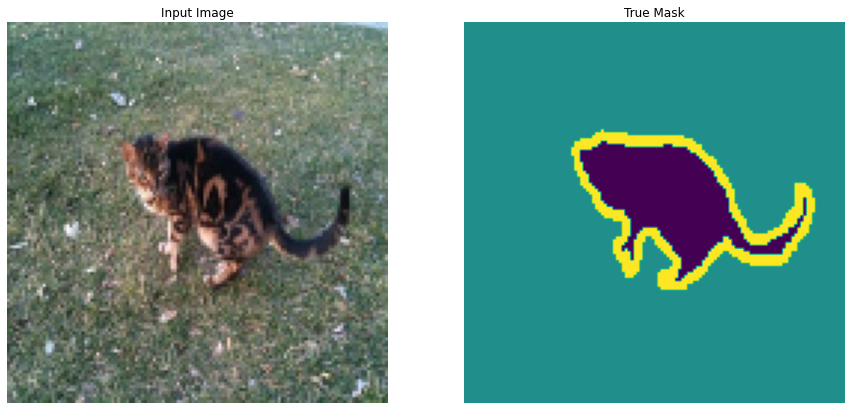

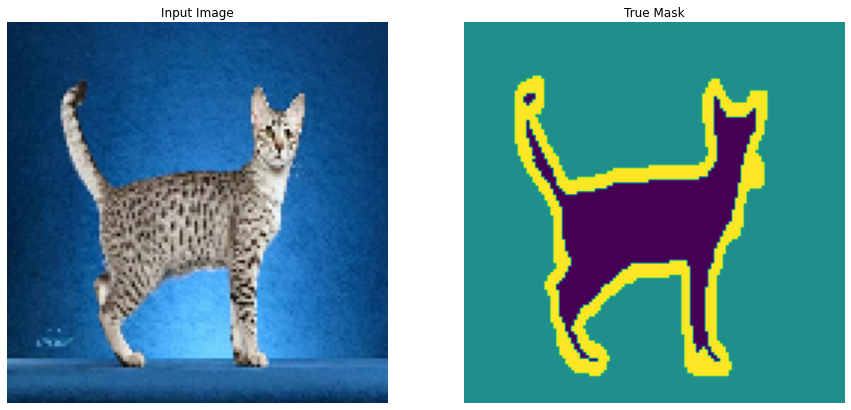

In [19]:

for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])


The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model—MobileNetV2—as the encoder.

In [20]:

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
for i in range(len(base_model.layers)):
  print(f'Layer num: {i}: ==> {base_model.layers[i]}')

Layer num: 0: ==> <keras.engine.input_layer.InputLayer object at 0x7fc33002d100>
Layer num: 1: ==> <keras.layers.convolutional.conv2d.Conv2D object at 0x7fc2aa155eb0>
Layer num: 2: ==> <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc330068be0>
Layer num: 3: ==> <keras.layers.activation.relu.ReLU object at 0x7fc2aa1550a0>
Layer num: 4: ==> <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fc3300689d0>
Layer num: 5: ==> <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc2aa163f70>
Layer num: 6: ==> <keras.layers.activation.relu.ReLU object at 0x7fc329f411c0>
Layer num: 7: ==> <keras.layers.convolutional.conv2d.Conv2D object at 0x7fc329f41c10>
Layer num: 8: ==> <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc329f43160>
Layer num: 9: ==> <keras.layers.convolutional.conv2d.Conv2D object at 0x7fc329f74280>
Layer num: 10: ==> <keras.layers.normalization.batch_normalizatio

The encoder is a pretrained MobileNetV2 model. You will use the model from tf.keras.applications. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [21]:
# Setup for encoder
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples (pix2pix):

In [22]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [23]:

# create unet_model
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # add data augmentation layer
  data_augmentation = tf.keras.Sequential(
      [tf.keras.layers.RandomFlip(mode='horizontal',seed=42),
       tf.keras.layers.RandomFlip(mode='horizontal',seed=42)]
  )

  augment = data_augmentation(inputs)

  # Downsampling through the model
  skips = down_stack(augment)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # add a dropout layer ==> does not appear to help in here
  # dropout = tf.keras.layers.Dropout(0.4)(x)
  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [24]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

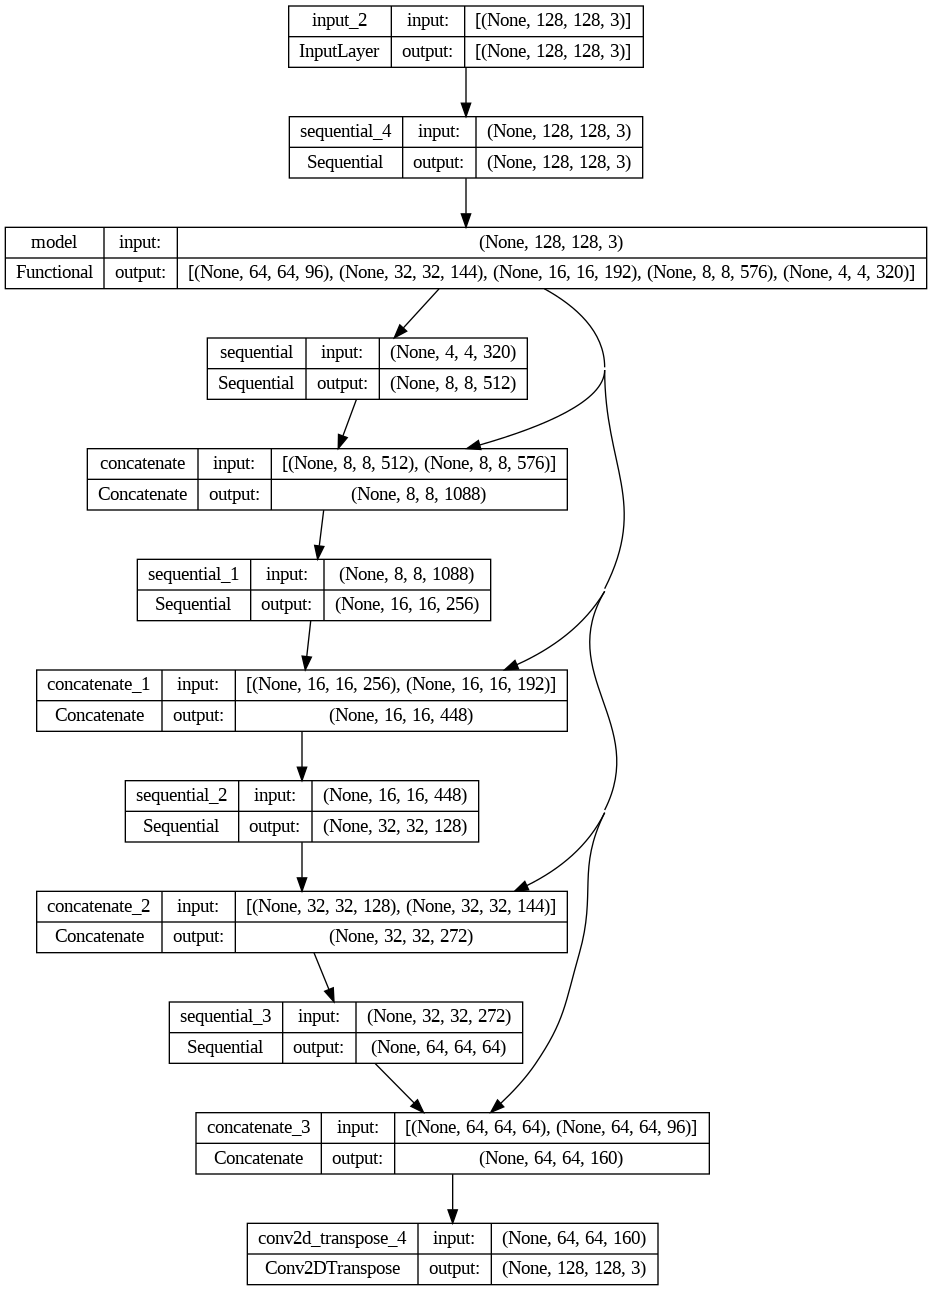

In [25]:
# Plot the resulting model architecture:
tf.keras.utils.plot_model(model, show_shapes=True)


Try out the model to check what it predicts before training:

In [26]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [27]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 10s 10s/step


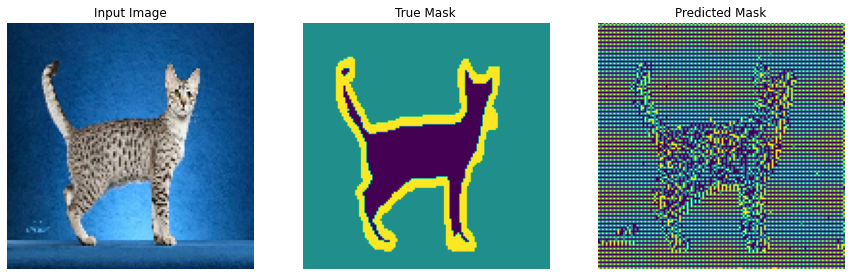

In [28]:
show_predictions()

In [29]:
# The callback defined below is used to observe how the model improves while 
# it is training:

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 38ms/step


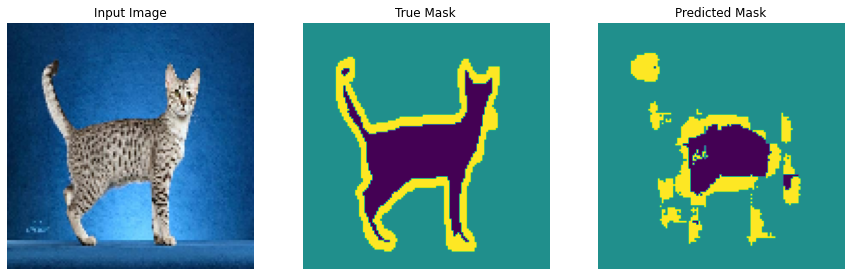


Sample Prediction after epoch 20

57/57 [==============================] - 13s 221ms/step - loss: 0.3268 - accuracy: 0.8667 - val_loss: 1.1506 - val_accuracy: 0.7017


In [30]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

In [ ]:
model_history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [31]:
def show_history(model,model_history):
  model.summary()
  
  acc = model_history.history['accuracy']
  val_acc = model_history.history['val_accuracy']

  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']
  

  epochs_range = model_history.epoch

  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')


  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')

    
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

  train_acc = model_history.history['accuracy'][-1]
  val_acc = model_history.history['val_accuracy'][-1]
  train_loss = model_history.history['loss'][-1]
  val_loss = model_history.history['val_loss'][-1]

  print(f'Training accuracy: {train_acc:.3f}\tTraining loss: {train_loss:.3f}')
  print(f'Validation accuracy: {val_acc:.3f}\tTraining loss: {val_loss:.3f}')


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_4 (Sequential)      (None, 128, 128, 3)  0           ['input_2[0][0]']                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['sequential_4[0][0]']           
                                , (None, 32, 32, 14                                               
                                4),                                                         

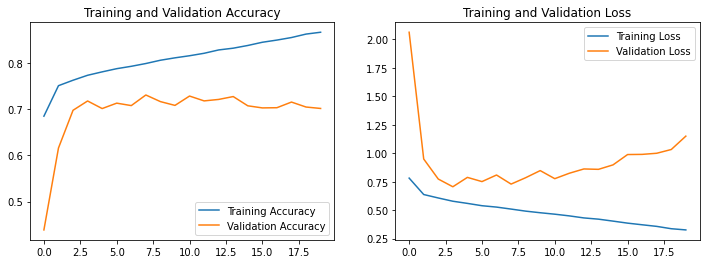

Training accuracy: 0.867	Training loss: 0.327
Validation accuracy: 0.702	Training loss: 1.151


In [32]:
show_history(model,model_history)

In [ ]:
#Part2====================================================================
# Reload Oxford-IIIT Pets dataset with X_train(75%),X_val(15%) and X_test(10%)

In [33]:
# see data augmetation
# split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
dataset2,info = tfds.load('oxford_iiit_pet:3.*.*', 
                                split=['train+test[:50%]',
                                       'test[50%:80%]',
                                       'test[80%:]'],
                                with_info=True)

In [34]:
print(f'Data size for training: {len(dataset2[0])}')
print(f'Data size for validation: {len(dataset2[1])}')
print(f'Data size for testing: {len(dataset2[2])}')

Data size for training: 5514
Data size for validation: 1101
Data size for testing: 734


In [ ]:
# DO NOT USE THIS!!!
# source https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438
# split dataset into 3 partitions (0.5,0.4,0.1)
def get_dataset_partitions_tf(ds, ds_size, train_split=0.5, val_split=0.4, 
                            test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [35]:
# resize images to 128X128 and normalize image pixels bwetween [0,1]
train_images_2 = dataset2[0].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_images_2 = dataset2[1].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images_2 = dataset2[2].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [36]:
# Build the input pipeline and include 
BUFFER_SIZE = 1000
BATCH_SIZE = 64

train_batches2 = (
    train_images_2
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches2 = (
    val_images_2
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches2 = (
    test_images_2
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [37]:
len(train_images_2)

5514

In [38]:
OUTPUT_CLASSES = 3

model2 = unet_model(output_channels=OUTPUT_CLASSES)
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

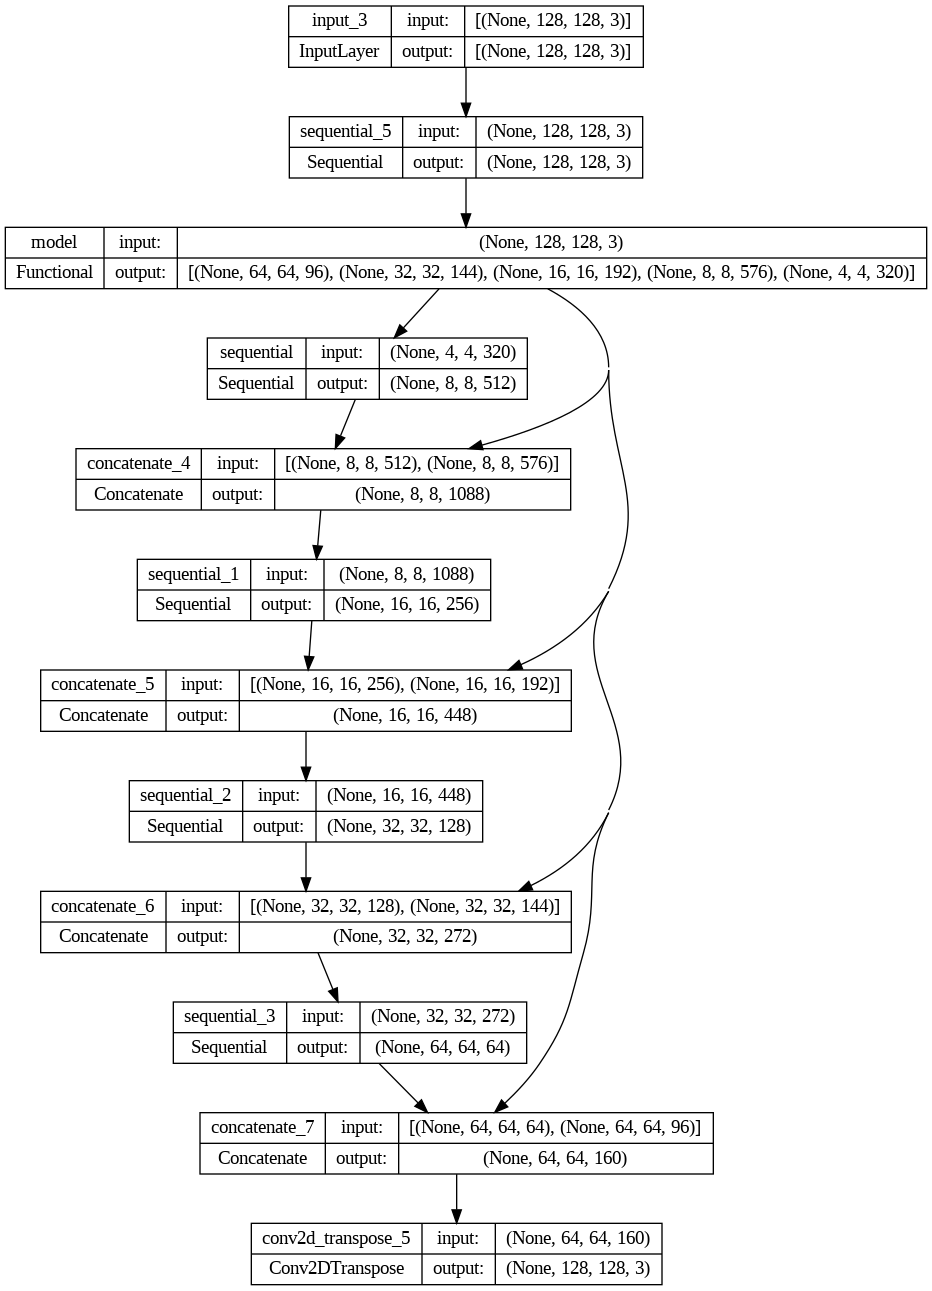

In [39]:
# Plot the resulting model architecture:
tf.keras.utils.plot_model(model2, show_shapes=True)

In [40]:
TRAIN_LENGTH2 = len(train_images_2)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH2 // BATCH_SIZE

In [41]:
model = model2

1/1 [==============================] - 0s 27ms/step


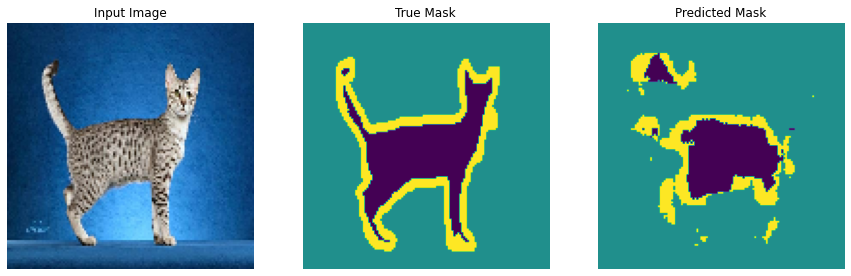


Sample Prediction after epoch 20

87/87 [==============================] - 15s 170ms/step - loss: 0.1934 - accuracy: 0.9200 - val_loss: 1.7831 - val_accuracy: 0.6739


In [42]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(val_images_2)//BATCH_SIZE//VAL_SUBSPLITS

model_history2 = model2.fit(train_batches2, epochs=EPOCHS,
                          validation_data=val_batches2,
                          callbacks=[DisplayCallback()])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_5 (Sequential)      (None, 128, 128, 3)  0           ['input_3[0][0]']                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['sequential_5[0][0]']           
                                , (None, 32, 32, 14                                               
                                4),                                                         

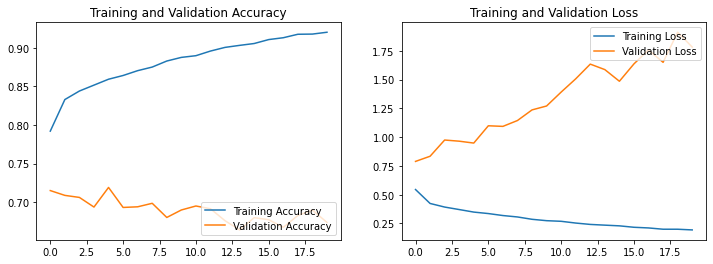

Training accuracy: 0.920	Training loss: 0.193
Validation accuracy: 0.674	Training loss: 1.783


In [43]:
show_history(model2,model_history2)
